# Sleep Data 

In [ ]:
from smbus2 import SMBus
import time, csv, datetime

I2C_ADDR = 0x57

# Register addresses
REG_INTR_ENABLE_1 = 0x02
REG_INTR_ENABLE_2 = 0x03
REG_FIFO_WR_PTR   = 0x04
REG_FIFO_OVF_CNT  = 0x05
REG_FIFO_RD_PTR   = 0x06
REG_FIFO_DATA     = 0x07
REG_MODE_CONFIG   = 0x09
REG_SPO2_CONFIG   = 0x0A
REG_LED1_PA       = 0x0C
REG_LED2_PA       = 0x0D

def init_sensor(bus):
    try:
        # Reset 
        bus.write_byte_data(I2C_ADDR, REG_MODE_CONFIG, 0x40)
        time.sleep(0.5)

        # Disable interrupts
        bus.write_byte_data(I2C_ADDR, REG_INTR_ENABLE_1, 0x00)
        bus.write_byte_data(I2C_ADDR, REG_INTR_ENABLE_2, 0x00)

        # Clear FIFO pointers
        bus.write_byte_data(I2C_ADDR, REG_FIFO_WR_PTR, 0x00)
        bus.write_byte_data(I2C_ADDR, REG_FIFO_OVF_CNT, 0x00)
        bus.write_byte_data(I2C_ADDR, REG_FIFO_RD_PTR, 0x00)

        # Set mode to HR only
        bus.write_byte_data(I2C_ADDR, REG_MODE_CONFIG, 0x02)

        # Set SPO2 config: sample rate 100Hz, pulse width 411us
        bus.write_byte_data(I2C_ADDR, REG_SPO2_CONFIG, 0x27)

        # Set LED power
        bus.write_byte_data(I2C_ADDR, REG_LED1_PA, 0x24)  # IR
        bus.write_byte_data(I2C_ADDR, REG_LED2_PA, 0x24)  # RED

        print(" Sensor initialized")
    except Exception as e:
        print(" Sensor init failed:", e)

def read_sample(bus):
    data = bus.read_i2c_block_data(I2C_ADDR, REG_FIFO_DATA, 6)
    red = (data[0] << 16 | data[1] << 8 | data[2]) & 0x03FFFF
    ir  = (data[3] << 16 | data[4] << 8 | data[5]) & 0x03FFFF
    return red, ir

# Begin logging
with SMBus(1) as bus, open("clean_heart_data.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["timestamp", "red", "ir"])

    init_sensor(bus)

    print(" Logging live data every 1s... Press Ctrl+C to stop.\n")
    try:
        while True:
            ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            try:
                red, ir = read_sample(bus)
                if red and ir and red > 500 and ir > 500:
                    writer.writerow([ts, red, ir])
                    print(f"{ts} → RED: {red} | IR: {ir}")
                else:
                    print(f"{ts} → Incomplete or low signal")
            except OSError:
                print(f"{ts} →  I²C read error, skipping")
            time.sleep(1)
    except KeyboardInterrupt:
        print("\n Logging stopped. Data saved to 'clean_heart_data.csv'")


# Data Example

# Converting the Heart Rate

IR signals and finds peaks to calculate heart rate

Data shape: (15829, 3)
First few rows:
             timestamp    red     ir
0  2025-05-03 23:00:00  20434  21367
1  2025-05-03 23:00:01  21578  22700
2  2025-05-03 23:00:02  21964  23273
3  2025-05-03 23:00:03  22545  24215
4  2025-05-03 23:00:04  22235  23303
Average sampling rate: 0.73 Hz
Using minimum peak distance: 2
Detected 2375 potential heartbeat peaks
Saved visualization to heart_rate_analysis.png

Results Summary:
Average Heart Rate: 88.2 BPM
Heart Rate Range: 48.0 - 120.0 BPM
Standard Deviation: 30.3 BPM
Total Duration: 21599.0 seconds
Detected 2375 potential heartbeats
Saved heart rate data to heart_rate_results.csv
{'average_hr': 88.23553783603414, 'min_hr': 47.99944441868451, 'max_hr': 119.9986110468095, 'std_hr': 30.270611561699315, 'num_peaks': 2375, 'duration_seconds': 21599.0}


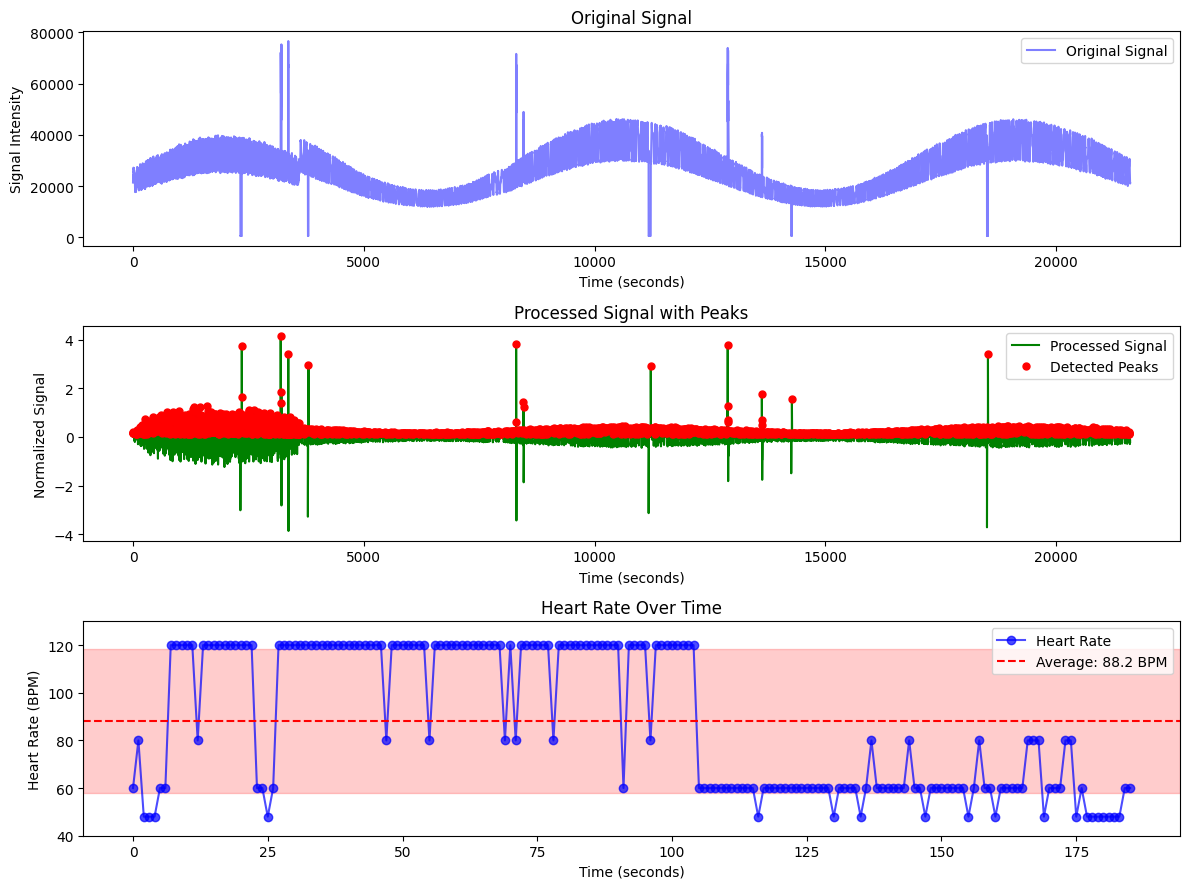

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy import interpolate
import io

def process_heart_data(data_text):
    """
    Process heart rate data from a text string.
    
    Parameters:
    data_text (str): Text content of the data file
    
    Returns:
    dict: Heart rate analysis results
    """
    # Load data from string instead of file
    try:
        # Try to parse as CSV with tab delimiter
        df = pd.read_csv(io.StringIO(data_text), sep='\t', header=None)
        
        # Check if we got expected columns
        if df.shape[1] >= 3:
            df.columns = ['timestamp', 'red', 'ir'] + [f'col_{i}' for i in range(3, df.shape[1])]
        else:
            # If not enough columns, try different parsing approach
            print("Data format doesn't match expected. Trying alternative parsing...")
            df = pd.read_csv(io.StringIO(data_text), header=None)
            if df.shape[1] >= 3:
                df.columns = ['timestamp', 'red', 'ir'] + [f'col_{i}' for i in range(3, df.shape[1])]
            else:
                raise ValueError("Could not parse data with expected columns")
    
        # Display the data structure to help debug
        print(f"Data shape: {df.shape}")
        print("First few rows:")
        print(df.head())
        
        # Convert columns to appropriate types
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        except:
            print("Couldn't parse timestamp as datetime. Using row numbers instead.")
            df['timestamp'] = pd.to_datetime(pd.date_range(start='2023-01-01', periods=len(df), freq='S'))
        
        df['red'] = pd.to_numeric(df['red'], errors='coerce')
        df['ir'] = pd.to_numeric(df['ir'], errors='coerce')
        
        # Drop rows with NaN values after conversion
        df = df.dropna(subset=['red', 'ir'])
        
        # If we have very little data after cleaning, abort
        if len(df) < 10:
            print("Not enough valid data points after cleaning")
            return None
            
    except Exception as e:
        print(f"Error parsing data: {e}")
        print("Attempting simplified parsing...")
        
        # Simplified parsing - just extract numeric values
        try:
            # Split by lines and extract numbers
            lines = data_text.strip().split('\n')
            data = []
            
            for line in lines:
                # Find all numbers in the line
                import re
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                if len(numbers) >= 2:  # At least need two values (time and signal)
                    data.append([float(n) for n in numbers[:3]])  # Take up to 3 values
            
            if not data:
                print("Could not extract numeric data from text")
                return None
                
            # Convert to dataframe
            df = pd.DataFrame(data)
            if df.shape[1] >= 2:
                columns = ['timestamp', 'red', 'ir'][:df.shape[1]]
                df.columns = columns
            else:
                print("Not enough columns in extracted data")
                return None
                
            # Create sequential timestamps if first column doesn't look like timestamps
            if df['timestamp'].max() < 1000000:  # Small values are likely not timestamps
                print("First column doesn't appear to be timestamps, creating sequential times")
                df['timestamp'] = np.arange(len(df))
        except Exception as e:
            print(f"Failed to parse data in simplified mode: {e}")
            return None
    
    # Calculate time in seconds
    if pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        # If timestamp is datetime type
        df['seconds'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
    else:
        # If timestamp is numeric, assume it's already in seconds or needs scaling
        if df['timestamp'].max() > 1000000:  # Large values might be milliseconds
            df['seconds'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 1000.0
        else:
            df['seconds'] = df['timestamp'] - df['timestamp'].iloc[0]
    
    # Choose which signal to use (IR is typically better for heart rate)
    if 'ir' in df.columns:
        signal = df['ir'].values
    else:
        signal = df['red'].values
    
    time = df['seconds'].values
    
    # Ensure we have enough data and valid time differences
    if len(time) < 10 or np.all(np.diff(time) == 0):
        print("Not enough data points or invalid time differences")
        return None
    
    # Calculate average sampling rate
    avg_fs = 1.0 / np.mean(np.diff(time))
    print(f"Average sampling rate: {avg_fs:.2f} Hz")
    
    # Ensure sampling rate is usable
    MIN_REQUIRED_FS = 4  # Minimum sampling rate for heart rate analysis
    
    if avg_fs < MIN_REQUIRED_FS:
        print(f"Warning: Sampling rate ({avg_fs:.2f} Hz) is very low. Resampling to {MIN_REQUIRED_FS} Hz")
        # Resample to higher rate
        t_regular = np.linspace(time[0], time[-1], int((time[-1]-time[0])*MIN_REQUIRED_FS))
        f = interpolate.interp1d(time, signal, kind='linear', bounds_error=False, fill_value='extrapolate')
        signal_regular = f(t_regular)
        time_regular = t_regular
        avg_fs = MIN_REQUIRED_FS
    else:
        # Use original signal
        signal_regular = signal
        time_regular = time
    
    # Normalize the signal (useful for heart rate analysis)
    signal_mean = np.mean(signal_regular)
    signal_std = np.std(signal_regular)
    if signal_std > 0:
        normalized_signal = (signal_regular - signal_mean) / signal_std
    else:
        print("Signal has zero standard deviation, cannot normalize")
        return None
    
    # Simple detrending (remove baseline wander)
    window_size = max(1, int(avg_fs * 5))  # 5 second window
    signal_baseline = pd.Series(normalized_signal).rolling(window=window_size, min_periods=1).mean().values
    detrended = normalized_signal - signal_baseline
    
    # Find peaks with appropriate distance
    min_distance = max(1, int(avg_fs * 0.5))  # No peaks closer than 0.5 seconds
    print(f"Using minimum peak distance: {min_distance}")
    
    peaks, _ = find_peaks(detrended, distance=min_distance, height=0.1)  # Find peaks above threshold
    
    if len(peaks) < 2:
        print("Not enough peaks detected. Try adjusting detection parameters.")
        return None
    
    print(f"Detected {len(peaks)} potential heartbeat peaks")
    
    # Calculate heart rates from peaks
    peak_times = time_regular[peaks]
    intervals = np.diff(peak_times)
    heart_rates = 60 / intervals  # Convert intervals to BPM
    
    # Filter out physiologically implausible values
    valid_hrs = heart_rates[(heart_rates >= 40) & (heart_rates <= 180)]
    
    if len(valid_hrs) == 0:
        print("No valid heart rates calculated after filtering")
        return None
    
    # Calculate heart rate statistics
    avg_hr = np.mean(valid_hrs)
    min_hr = np.min(valid_hrs)
    max_hr = np.max(valid_hrs)
    hr_std = np.std(valid_hrs)
    
    # Create visualization
    plt.figure(figsize=(12, 9))
    
    # Plot the original signal
    plt.subplot(3, 1, 1)
    plt.plot(time, signal, 'b-', alpha=0.5, label='Original Signal')
    plt.title('Original Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal Intensity')
    plt.legend()
    
    # Plot the processed signal with peaks
    plt.subplot(3, 1, 2)
    plt.plot(time_regular, detrended, 'g-', label='Processed Signal')
    plt.plot(peak_times, detrended[peaks], 'ro', markersize=5, label='Detected Peaks')
    plt.title('Processed Signal with Peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Signal')
    plt.legend()
    
    # Plot the heart rate over time
    plt.subplot(3, 1, 3)
    
    # FIX: Make sure the x and y arrays have the same length
    hr_times = peak_times[:-1]  # These correspond to intervals
    
    # Check and fix if lengths are different
    if len(hr_times) != len(valid_hrs):
        print(f"Warning: Size mismatch between times ({len(hr_times)}) and values ({len(valid_hrs)})")
        # Option 1: Use indices for x-axis
        plt.plot(valid_hrs, 'b-o', alpha=0.7, label='Heart Rate')
    else:
        # Option 2: Use actual times for x-axis
        plt.plot(hr_times, valid_hrs, 'b-o', alpha=0.7, label='Heart Rate')
    
    # Add average line
    plt.axhline(y=avg_hr, color='r', linestyle='--', 
              label=f'Average: {avg_hr:.1f} BPM')
    
    # Add standard deviation range (without using hr_times to avoid errors)
    plt.axhspan(avg_hr - hr_std, avg_hr + hr_std, color='r', alpha=0.2)
    
    plt.title('Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.ylim(max(40, min_hr-10), min(180, max_hr+10))
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('heart_rate_analysis.png')
    print("Saved visualization to heart_rate_analysis.png")
    
    # Create results summary
    results = {
        'average_hr': float(avg_hr),
        'min_hr': float(min_hr),
        'max_hr': float(max_hr),
        'std_hr': float(hr_std),
        'num_peaks': int(len(peaks)),
        'duration_seconds': float(time[-1] - time[0])
    }
    
    print(f"\nResults Summary:")
    print(f"Average Heart Rate: {avg_hr:.1f} BPM")
    print(f"Heart Rate Range: {min_hr:.1f} - {max_hr:.1f} BPM")
    print(f"Standard Deviation: {hr_std:.1f} BPM")
    print(f"Total Duration: {time[-1] - time[0]:.1f} seconds")
    print(f"Detected {len(peaks)} potential heartbeats")
    
    # Save results to CSV
    hr_df = pd.DataFrame({
        'heart_rate': valid_hrs
    })
    # Add time if available and matching
    if len(hr_times) == len(valid_hrs):
        hr_df['time'] = hr_times
    hr_df.to_csv('heart_rate_results.csv', index=False)
    print("Saved heart rate data to heart_rate_results.csv")
    
    return results

# Usage
if __name__ == "__main__":
    # Read the data file
    with open('sleep_heart_data.txt', 'r') as f:
        data_text = f.read()
    
    # Process the data
    results = process_heart_data(data_text)
    print(results)

# This was built and deployed in Rasberry Pi

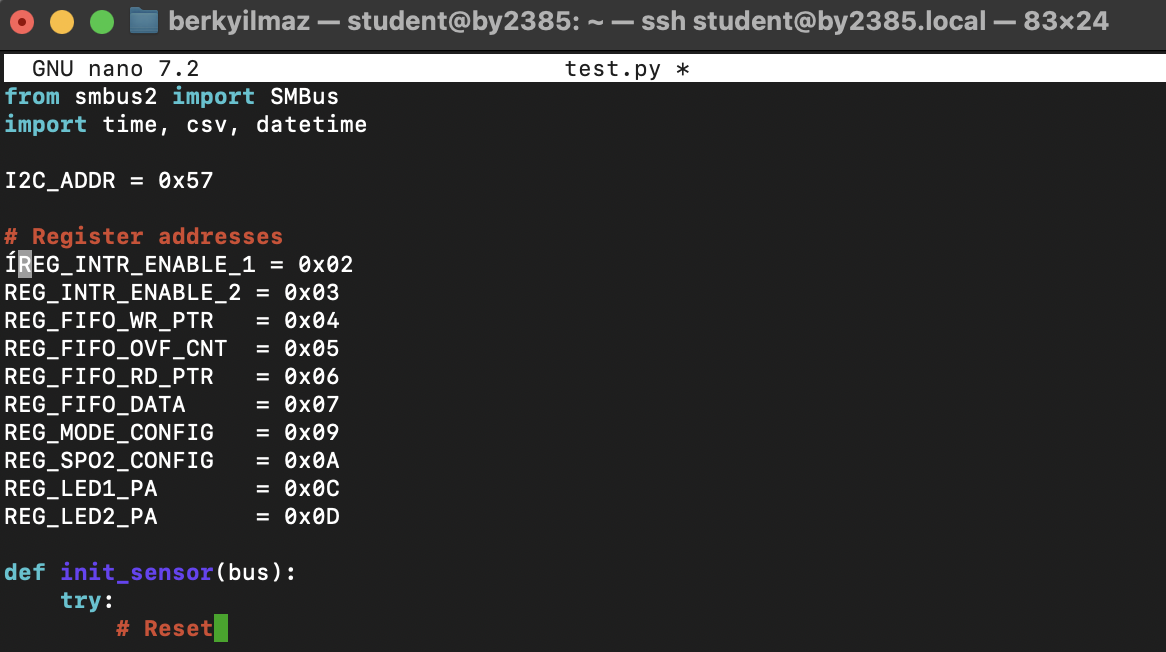

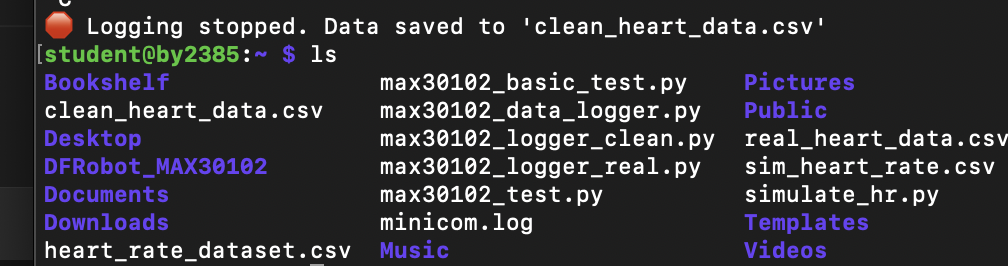